In [1]:
import pandas as pd
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Cargar datos
df = pd.read_csv("top_10_corr.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# Pivotear: filas = productos, columnas = fechas
df_pivot = df.pivot_table(index='product_id', columns='periodo', values='tn', aggfunc='sum').fillna(0)

# Asegurar formato [n_series, n_timestamps, 1]
X = df_pivot.values[:, :, np.newaxis]

# Normalizar (opcional pero recomendado para DTW)
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(X)

# Clustering con DTW
n_clusters = 5  # podés cambiarlo según el caso
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
labels = km_dtw.fit_predict(X_scaled)

# Guardar resultado
df_clusters = pd.DataFrame({
    'product_id': df_pivot.index,
    'cluster_dtw': labels
})
df_clusters.to_csv("dtw_clusters10+hp.csv", index=False)
print("✅ Archivo dtw_clusters10+hp.csv generado correctamente.")


c:\Users\waldo\miniconda3\envs\tslearn_env\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
c:\Users\waldo\miniconda3\envs\tslearn_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\waldo\miniconda3\envs\tslearn_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\waldo\miniconda3\envs\tslearn_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\waldo\miniconda3\envs\tslearn_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all

✅ Archivo dtw_clusters10+hp.csv generado correctamente.


In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar datasets
df = pd.read_csv("top_10_corr.csv")
df['periodo'] = pd.to_datetime(df['periodo'])
df_clusters = pd.read_csv("dtw_clusters10+hp.csv")  # columnas: product_id, cluster_dtw

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Agregar cluster
df_prod = df_prod.merge(df_clusters, on='product_id', how='left')

# 4. Promedio histórico de febreros (2017–2019)
feb_hist = df_prod[
    (df_prod['periodo'].dt.month == 2) & (df_prod['periodo'].dt.year < 2020)
].groupby('product_id')['tn'].mean().reset_index()
feb_hist.rename(columns={'tn': 'febrero_hist'}, inplace=True)

# 5. Media móvil 12 meses
df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 6. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 7. Features derivados
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 8. Preparar entrenamiento
df_train = df_lags.dropna()

features = [
    'lag_1', 'lag_2', 'lag_3', 'mes',
    'media_movil_12m', 'var_lag1_lag2',
    'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1',
    'cluster_dtw'
]
target = 'tn'

train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features].copy()
y_train = train_data[target]
X_val = val_data[features].copy()
y_val = val_data[target]

# Conversión a float32 explícita
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# 9. Entrenar modelo
mejores_params = {
    #'n_estimators': 785,
    #'learning_rate': 0.18653015174111026,
    #'max_depth': 11,
    #'num_leaves': 71,
    #'subsample': 0.7024235263217672,
    #'colsample_bytree': 0.9074524979930358,
    #'random_state': 42,
    #'min_data_in_leaf': 21,
    #'reg_alpha': 1.5636957024741795,
    #'reg_lambda': 2.596019277530776,
    #'linear_tree': True
    
    'n_estimators': 650,
    'learning_rate': 0.06554567474084429,
    'max_depth': 13,
    'num_leaves': 332,
    'min_data_in_leaf': 10,
    'min_child_weight': 6.095438516027658,
    'subsample': 0.7323507708293469,
    'subsample_freq': 2,
    'colsample_bytree': 0.9753122515178971,
    'colsample_bynode': 0.9962401899153188,
    'reg_alpha': 0.5565385534598533,
    'reg_lambda': 0.056418296120399614,
    'max_bin': 452,
    'min_split_gain': 0.8619132163301192,
    'cat_smooth': 25.461036283753867,
    'random_state': 42,
    'verbosity': -1,
    'linear_tree': True
}

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train columns:", X_train.columns.tolist())
print(X_train.head())

modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 10. Validación
y_pred_val = modelo.predict(X_val)
print("📊 MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 11. Preparar predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = df_prod['product_id'].unique()
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['mes'] = 2

lag1_df = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']].rename(columns={'media_movil_12m': 'lag_1'})
lag2 = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_2'})
lag3 = df_prod[df_prod['periodo'] == '2019-11-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_3'})
media_mov = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]
clusters = df_clusters.copy()

feb_df = feb_df.merge(lag1_df, on='product_id')
feb_df = feb_df.merge(lag2, on='product_id')
feb_df = feb_df.merge(lag3, on='product_id')
feb_df = feb_df.merge(media_mov, on='product_id')
feb_df = feb_df.merge(clusters, on='product_id')

feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df = feb_df.merge(feb_hist, on='product_id', how='left')
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# Conversión a float32 para predicción
X_feb = feb_df[features].astype('float32')

# 12. Predicción
feb_df['tn_predicho'] = modelo.predict(X_feb)
feb_df['tn_predicho_ajustada'] = 0.65 * feb_df['tn_predicho'] + 0.35 * feb_df['febrero_hist']

# 13. Exportar
resultado = feb_df[['product_id', 'tn_predicho_ajustada']].rename(columns={'tn_predicho_ajustada': 'tn_predicho'})
resultado.to_csv("prediccion_feb2020_top10+hp.csv", index=False)
print("✅ Predicción febrero 2020 guardada en prediccion_feb2020_top10+hp.csv")


X_train shape: (12627, 10)
y_train shape: (12627,)
X_train columns: ['lag_1', 'lag_2', 'lag_3', 'mes', 'media_movil_12m', 'var_lag1_lag2', 'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1', 'cluster_dtw']
         lag_1      lag_2      lag_3   mes  media_movil_12m  var_lag1_lag2  \
34  127.756630   7.780320   0.000000  11.0        22.493889      16.420485   
69   86.107887  42.718040   0.000000  10.0        18.964170       2.015727   
70   98.744118  86.107887  42.718040  11.0        27.646717       1.146749   
86   16.288260  18.864849   0.000000   3.0         5.027022       0.863418   
87   25.171160  16.288260  18.864849   4.0         6.981976       1.545356   

    delta_lag1_lag2  delta_rel_lag1_lag2  delta_ma12_lag1  cluster_dtw  
34       119.976311            15.420485       105.262741          1.0  
69        43.389851             1.015727        67.143723          1.0  
70        12.636230             0.146749        71.097404          1.0  
86        -2.576590     

In [2]:
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_top10+hp.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("top_10_corr.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo           tn
1  2017-02-01  2345.422800
2  2017-03-01  3028.434380
3  2017-04-01  2553.149950
4  2017-05-01  3052.176300
5  2017-06-01  2964.369730
6  2017-07-01  2304.377120
7  2017-08-01  2335.195810
8  2017-09-01  2576.919270
9  2017-10-01  3048.054470
10 2017-11-01  2942.112830
11 2017-12-01  2613.707190
12 2018-01-01  2604.286540
13 2018-02-01  2780.208900
14 2018-03-01  3975.893070
15 2018-04-01  3381.348610
16 2018-05-01  3555.869760
17 2018-06-01  3214.209570
18 2018-07-01  3014.806210
19 2018-08-01  3036.273010
20 2018-09-01  2701.475140
21 2018-10-01  2856.380070
22 2018-11-01  2630.077270
23 2018-12-01  2455.276660
24 2019-01-01  2621.342580
25 2019-02-01  2879.038170
26 2019-03-01  3800.278810
27 2019-04-01  3430.869050
28 2019-05-01  3911.911160
29 2019-06-01  4106.024350
30 2019-07-01  4339.282220
31 2019-08-01  3393.905380
32 2019-09-01  4208.801630
33 2019-10-01  4651.287890
34 2019-11-01 


📌 Importancia de variables:
               feature  importancia
2                lag_3         5214
8      delta_ma12_lag1         4514
1                lag_2         4423
0                lag_1         4055
6      delta_lag1_lag2         3999
5        var_lag1_lag2         3981
4      media_movil_12m         3932
3                  mes         2603
9          cluster_dtw          989
7  delta_rel_lag1_lag2          754


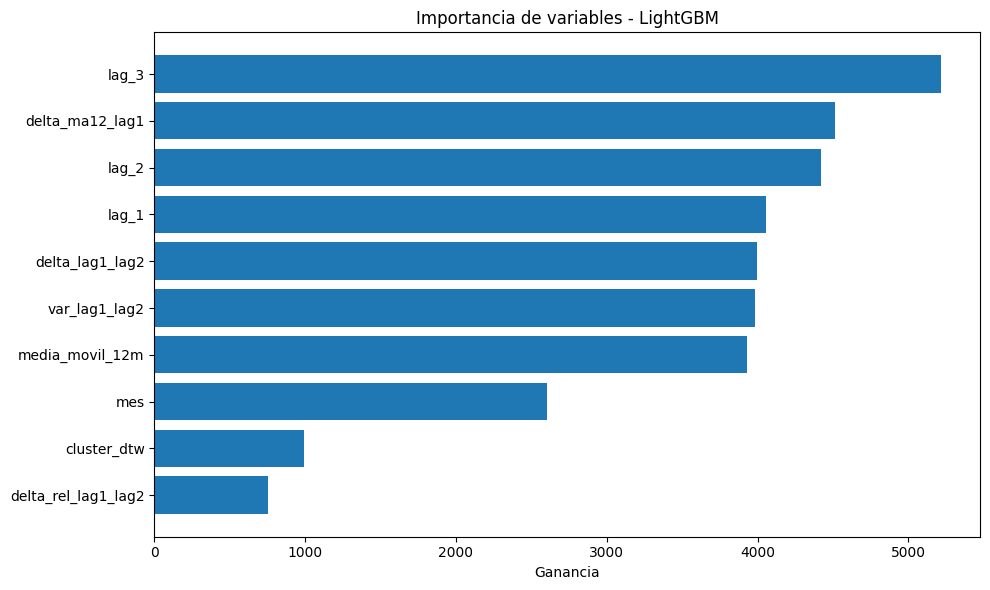

In [5]:
# 🔍 Importancia de variables
import matplotlib.pyplot as plt

# Crear DataFrame con la importancia
importancias = pd.DataFrame({
    'feature': modelo.feature_name_,
    'importancia': modelo.feature_importances_
}).sort_values(by='importancia', ascending=False).head(10)

# Mostrar en consola
print("\n📌 Importancia de variables:")
print(importancias)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importancias['feature'], importancias['importancia'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables - LightGBM")
plt.xlabel("Ganancia")
plt.tight_layout()
plt.show()


In [6]:
# Comparación por producto
comparacion = feb_df[['product_id', 'tn_predicho', 'tn_predicho_ajustada', 'febrero_hist']].copy()

# Totales agregados
total_modelo = comparacion['tn_predicho'].sum()
total_ajustada = comparacion['tn_predicho_ajustada'].sum()
total_febrero_hist = comparacion['febrero_hist'].sum()

print("🔎 Comparación de totales:")
print(f"📉 Predicción solo modelo...........: {total_modelo:,.2f} tn")
print(f"⚖️  Predicción ajustada (65/35)......: {total_ajustada:,.2f} tn")
print(f"📜 Promedio histórico febreros.......: {total_febrero_hist:,.2f} tn")

# Exportar comparación por producto (opcional)
#comparacion.to_csv("comparacion_feb2020.csv", index=False)
#print("📁 Comparación por producto guardada en comparacion_feb2020.csv")


🔎 Comparación de totales:
📉 Predicción solo modelo...........: 4,773.82 tn
⚖️  Predicción ajustada (65/35)......: 4,036.86 tn
📜 Promedio histórico febreros.......: 2,668.22 tn
